In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from calibration import Calibration
from utils import display
import preprocessing

In [2]:
# sample images
test_images = glob.glob('test_images/*.jpg')
project_images = glob.glob('test_images/video_samples/project*.jpg')
challange_images = glob.glob('test_images/video_samples/challange*.jpg')
harder_challange_images = glob.glob('test_images/video_samples/harder_challange*.jpg')

## Camera Calibration

In [3]:
cal = Calibration(nx=9, ny=6)
cal.compute_cal('camera_cal/calibration*.jpg')
print(cal)

Loaded camera config from file: calibration.pkl
Camera matrix: 
[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Dist coefficients: 
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]



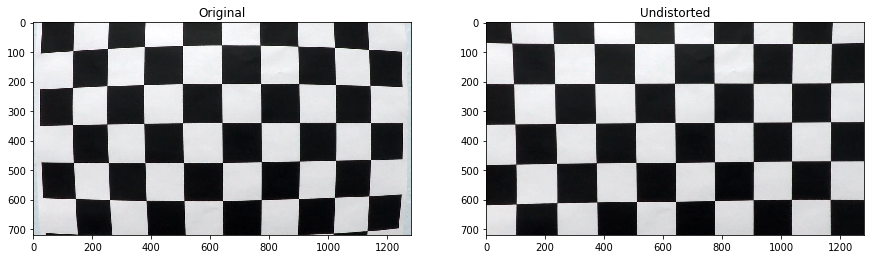

In [4]:
# undistort sample image
# note this image was not used for calibration because all corners could not be found
img = cv2.imread('camera_cal/calibration1.jpg')
# undistort image
dst = cal.undistort(img)
display([img, dst,], ['Original', 'Undistorted'], figsize=(23,10))
# display([img, dst,], ['Original', 'Undistorted'], figsize=(23,10), fname='calibration.jpg')

## Color Spaces

RGB


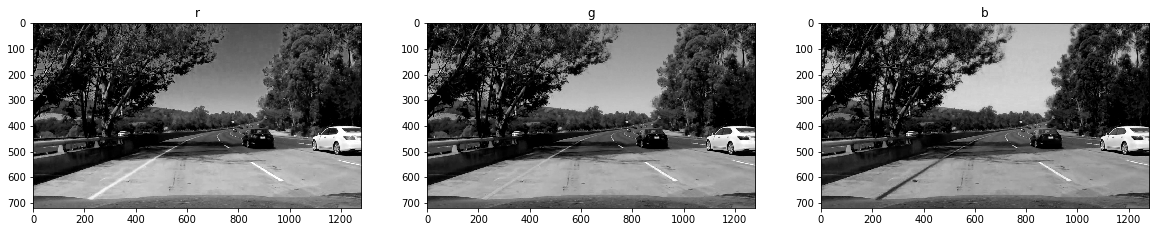

HSV


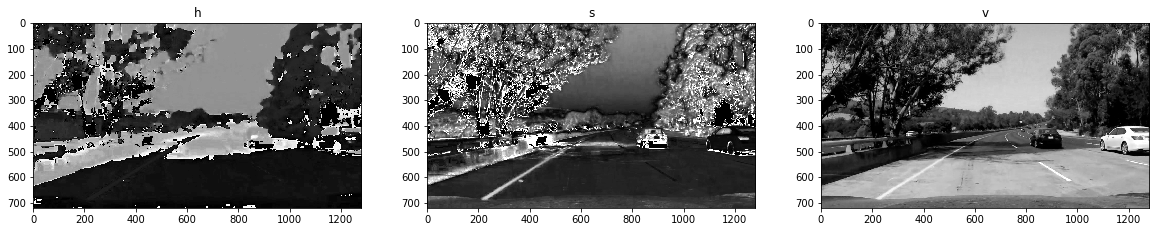

HLS


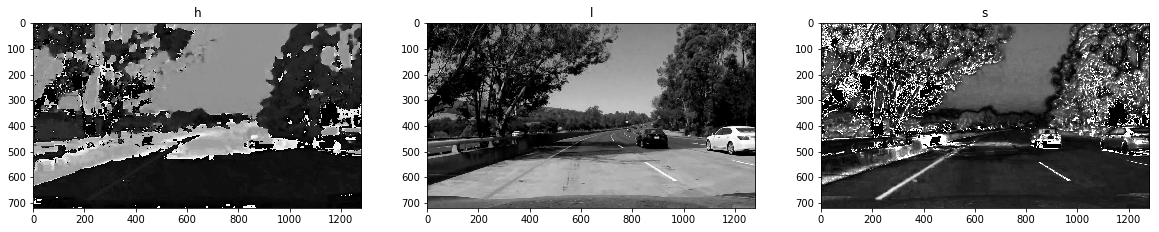

LAB


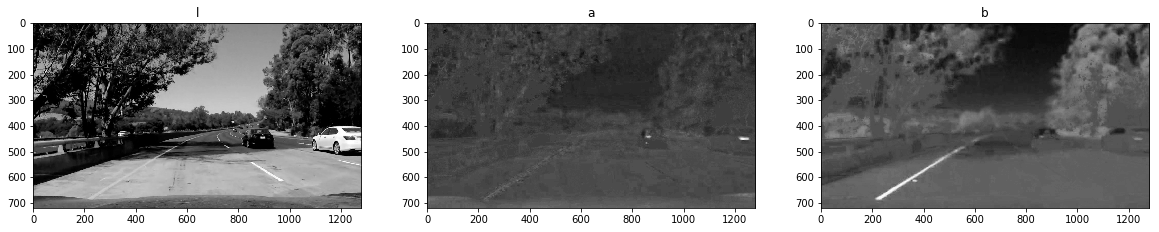

In [5]:
# color spaces test
img = mpimg.imread(test_images[1])
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
print("RGB")
display([img[:,:,0], img[:,:,1], img[:,:,2]], ['r','g','b'], cmap='gray', figsize=(20,10))
print("HSV")
display([hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]], ['h','s','v'], cmap='gray', figsize=(20,10))
print("HLS")
display([hls[:,:,0], hls[:,:,1], hls[:,:,2]], ['h','l','s'], cmap='gray', figsize=(20,10))
print("LAB")
display([lab[:,:,0], lab[:,:,1], lab[:,:,2]], ['l','a','b'], cmap='gray', figsize=(20,10))

Red, green and HLS saturation channel give the best results for yellow and white lines. 

## Gradient Thresholding

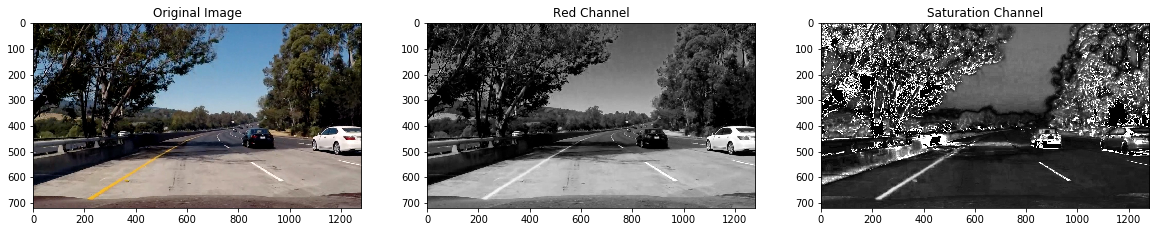

In [6]:
# gradients test
img = mpimg.imread(test_images[1])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
r_channel = img[:,:,0]
s_channel = hls[:,:,2]
display([img, r_channel, s_channel], ['Original Image', 'Red Channel', 'Saturation Channel'], figsize=(20,10), cmap='gray')

Using red channel


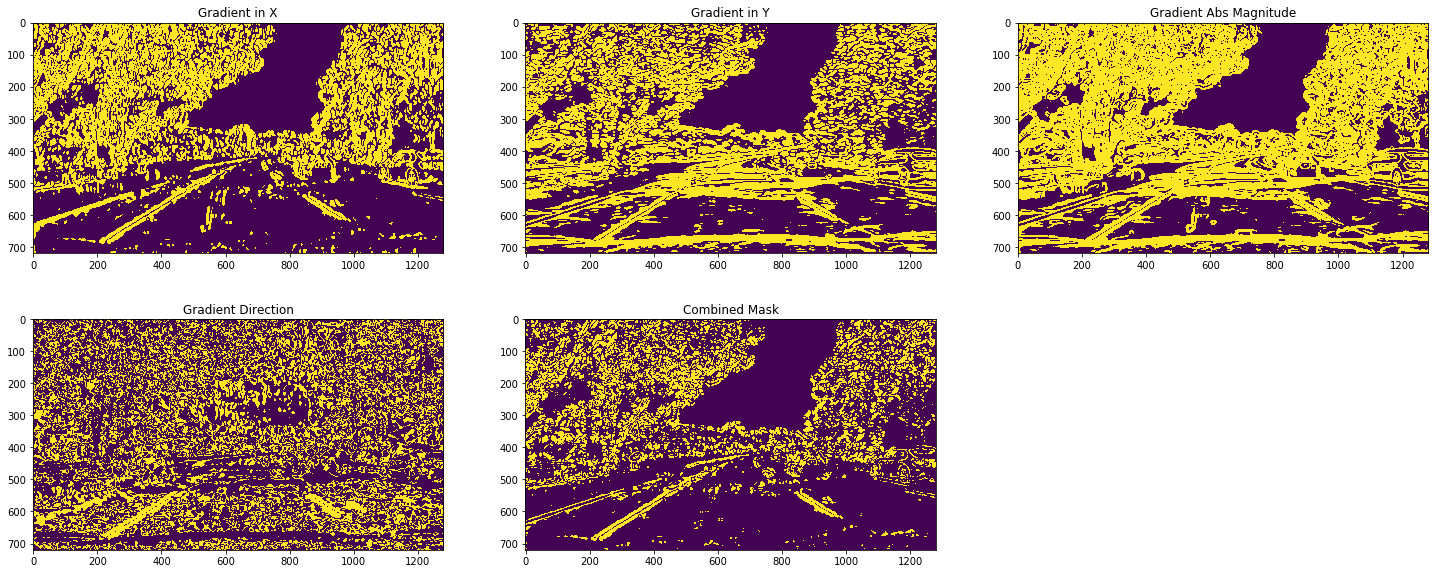

In [7]:
# red channel
print("Using red channel")
r_channel = img[:,:,0]
r_channel = cv2.GaussianBlur(r_channel, (19,19), 0)
grad_x = preprocessing.abs_sobel_thresh(r_channel, 'x', sobel_kernel=9, thresh=(10,100))
grad_y = preprocessing.abs_sobel_thresh(r_channel, 'y', sobel_kernel=9, thresh=(10,100))
grad_mag = preprocessing.mag_thresh(r_channel, sobel_kernel=9, thresh=(10,100))
grad_dir = preprocessing.dir_thresh(r_channel, sobel_kernel=19, thresh=(0.7, 1.3))

combined_r = np.zeros_like(r_channel)
combined_r[((grad_x == 1) & (grad_y == 1) & (grad_mag == 1))] = 1

display([grad_x, grad_y, grad_mag, grad_dir, combined_r], 
        ['Gradient in X', 'Gradient in Y', 'Gradient Abs Magnitude', 'Gradient Direction', 'Combined Mask'],
       figsize=(25,10))

Using saturation channel


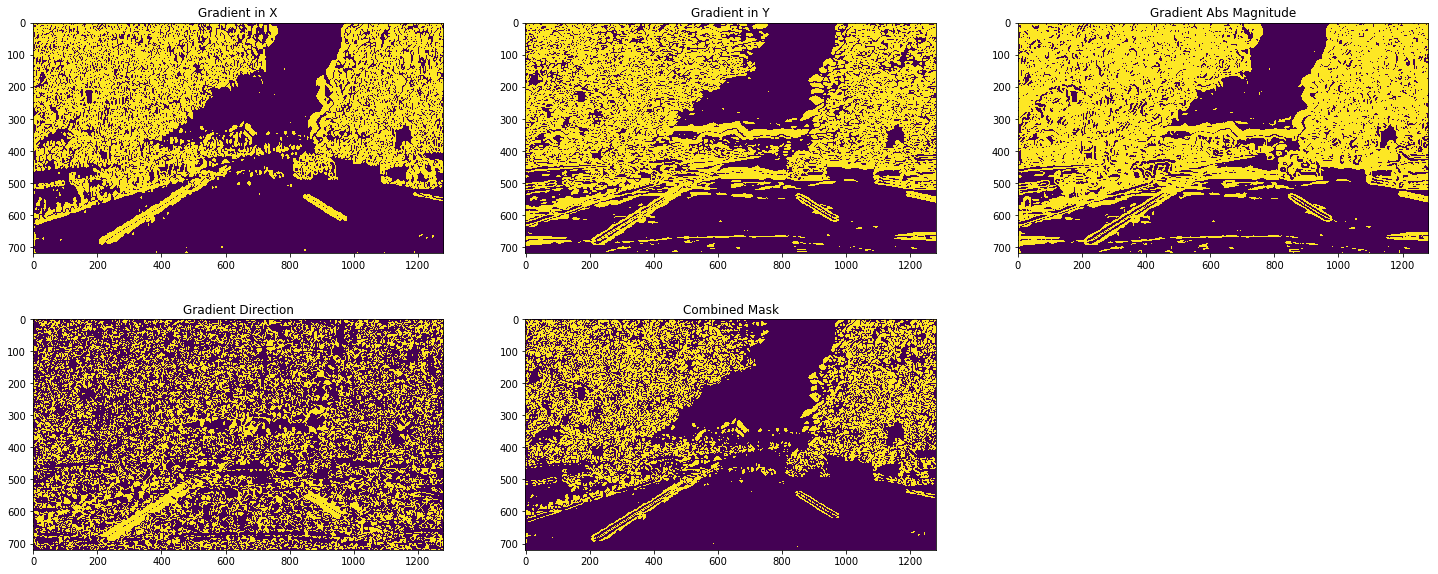

In [8]:
# sat channel
print("Using saturation channel")
s_channel = hls[:,:,2]
s_channel = cv2.GaussianBlur(s_channel, (19,19), 0)
grad_x = preprocessing.abs_sobel_thresh(s_channel, 'x', sobel_kernel=9, thresh=(10,100))
grad_y = preprocessing.abs_sobel_thresh(s_channel, 'y', sobel_kernel=9, thresh=(10,100))
grad_mag = preprocessing.mag_thresh(s_channel, sobel_kernel=9, thresh=(10,100))
grad_dir = preprocessing.dir_thresh(s_channel, sobel_kernel=19, thresh=(0.7, 1.3))

combined_s = np.zeros_like(s_channel)
combined_s[((grad_x == 1) & (grad_y == 1) & (grad_mag == 1))] = 1

display([grad_x, grad_y, grad_mag, grad_dir, combined_s], 
        ['Gradient in X', 'Gradient in Y', 'Gradient Abs Magnitude', 'Gradient Direction', 'Combined Mask'],
        figsize=(25,10))

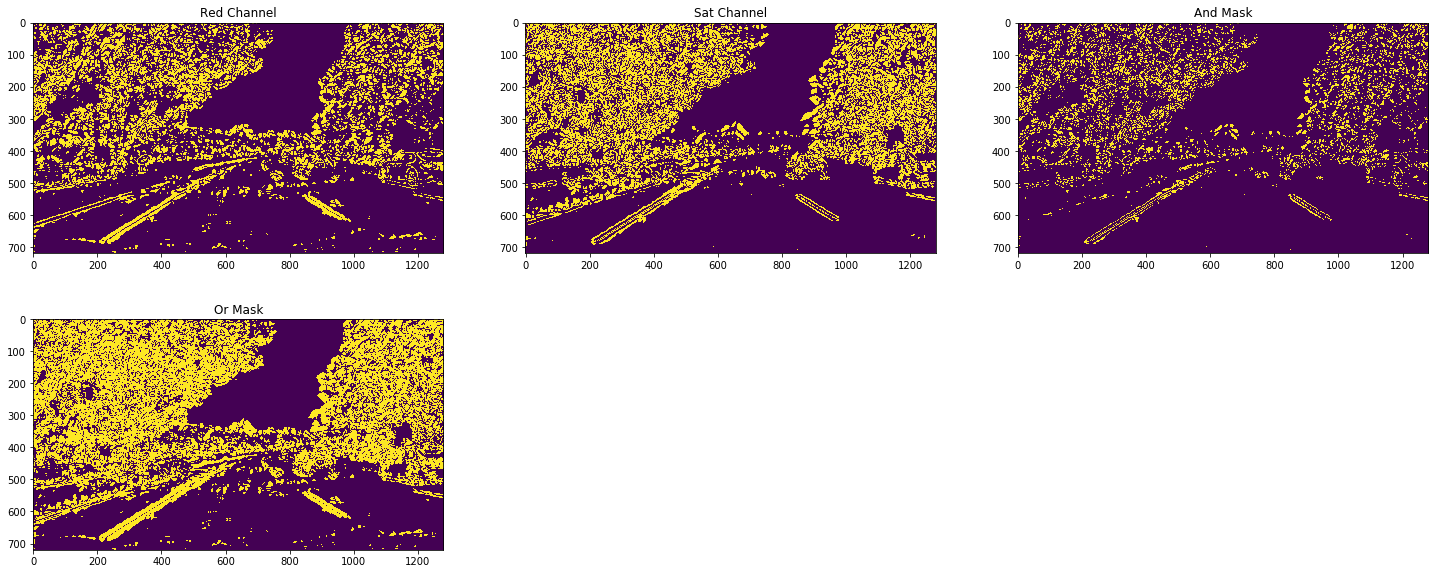

In [9]:
mask_and = np.zeros_like(combined_r)
mask_and[(combined_r == 1) & (combined_s == 1)] = 1

mask_or = np.zeros_like(combined_r)
mask_or[(combined_r == 1) | (combined_s == 1)] = 1

display([combined_r, combined_s, mask_and, mask_or], 
        ['Red Channel', 'Sat Channel', 'And Mask', 'Or Mask'],
        figsize=(25,10))

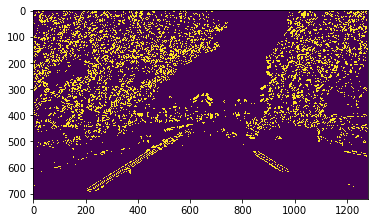

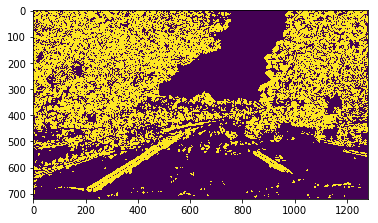

In [10]:
# settings
settings = preprocessing.MaskSetting()
settings.blur = 19
settings.grad_x = preprocessing.GradientSetting(9, (10,100))
settings.grad_y = preprocessing.GradientSetting(9, (10,100))
settings.grad_mag = preprocessing.GradientSetting(9, (10,100))

_,_,mask = preprocessing.gradient_mask(img, settings)
plt.imshow(mask); plt.show()

_,_,mask = preprocessing.gradient_mask(img, settings, 'or')
plt.imshow(mask); plt.show()

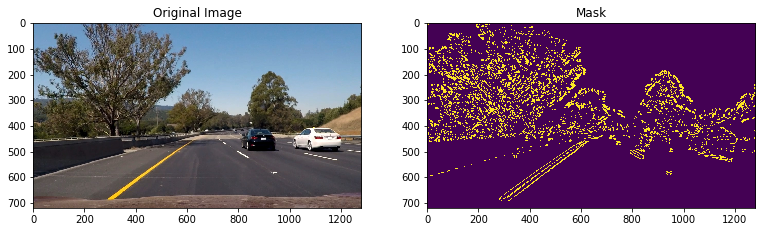

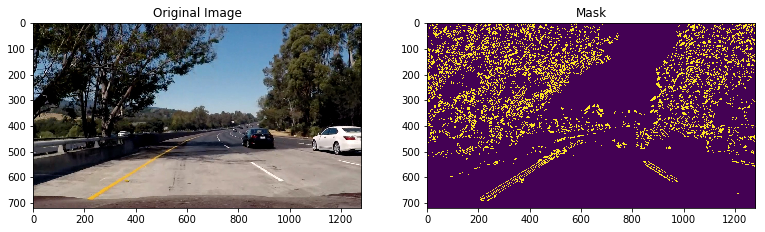

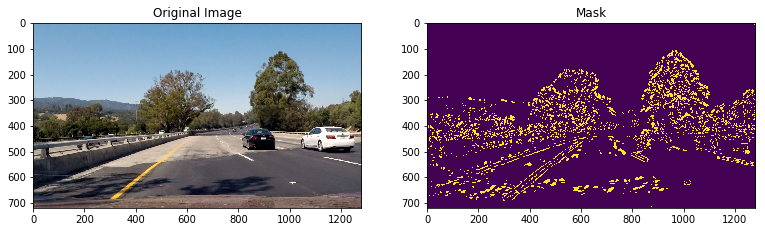

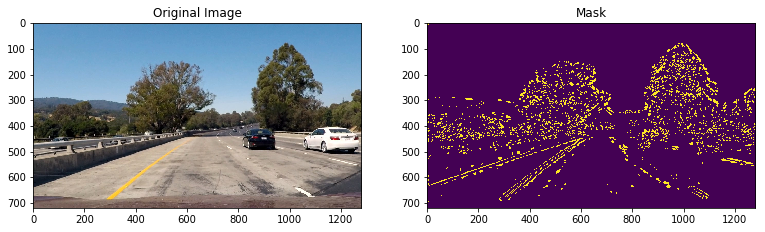

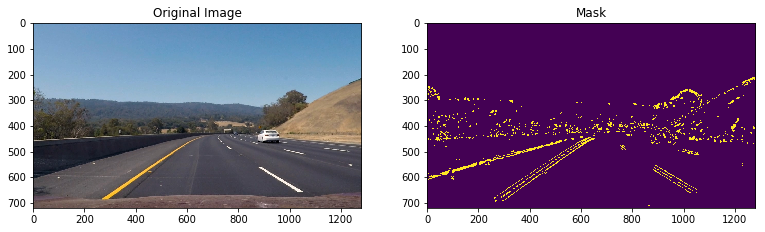

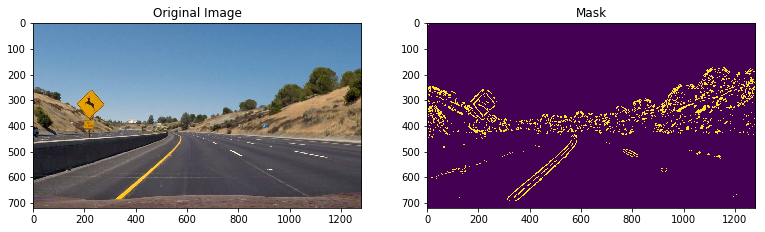

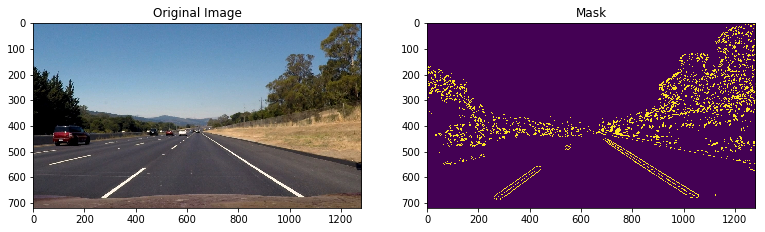

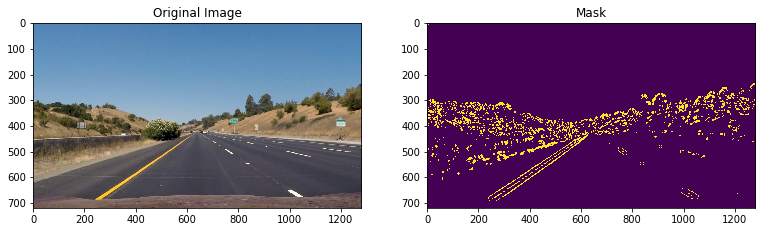

In [11]:
for fname in test_images:
    img = mpimg.imread(fname)
    _,_,mask = preprocessing.gradient_mask(img, settings, 'and')
    display([img, mask], ['Original Image', 'Mask'], figsize=(20,10))

## Image wrapping and shape masking

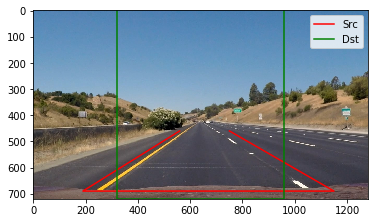

In [12]:
image_straight_lines = mpimg.imread(test_images[7])
roi_src = np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32')
roi_dst = np.array([[320, 0], [320,720], [960,720], [960, 0]], dtype='float32')
plt.plot(roi_src[:,0], roi_src[:,1], 'r-')
plt.plot(roi_dst[:,0], roi_dst[:,1], 'g-')
plt.legend(['Src', 'Dst'])
plt.imshow(image_straight_lines)

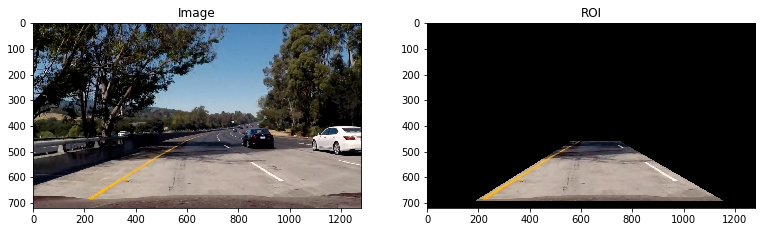

In [13]:
img = mpimg.imread(test_images[1])
roi_mask = preprocessing.roi(img, roi_src)
display([img, roi_mask], ['Image', 'ROI'], figsize=(20,8))

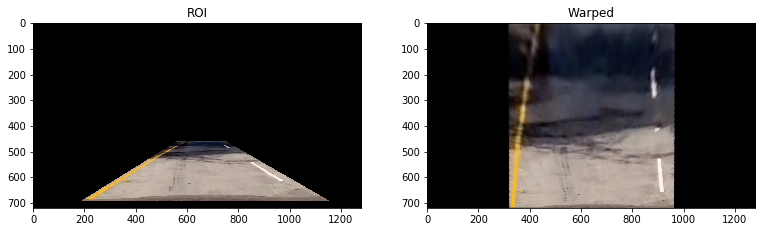

In [14]:
M, M_inv = preprocessing.get_prespective_transform(roi_src, roi_dst)
warped = preprocessing.warp_image(roi_mask, M)
display([roi_mask, warped], ['ROI', 'Warped'], figsize=(20,8))

## Image Pipeline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").

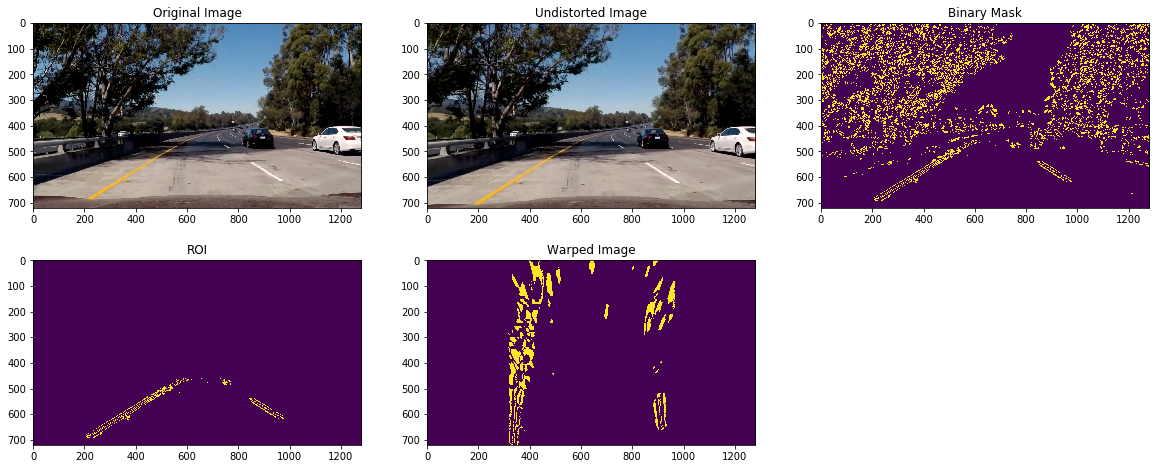

In [15]:
img = mpimg.imread(test_images[1])
# undistort
dst = cal.undistort(img)
# create binary mask
_,_,mask = preprocessing.gradient_mask(img, settings, 'and')
# roi
roi = preprocessing.roi(mask, roi_src)
# warp image
warped = preprocessing.warp_image(roi, M)
display([img, dst, mask, roi, warped], 
        ['Original Image', 'Undistorted Image', 'Binary Mask', 'ROI', 'Warped Image'], 
        figsize=(20,8))

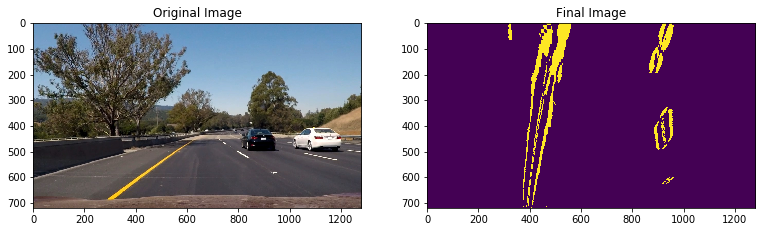

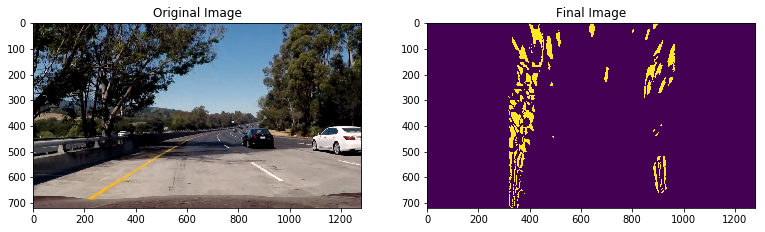

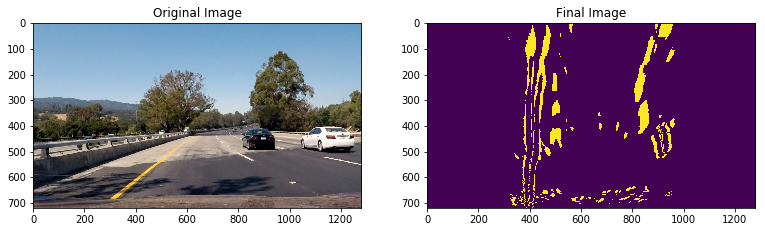

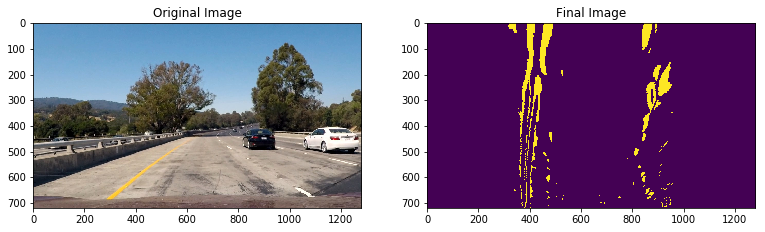

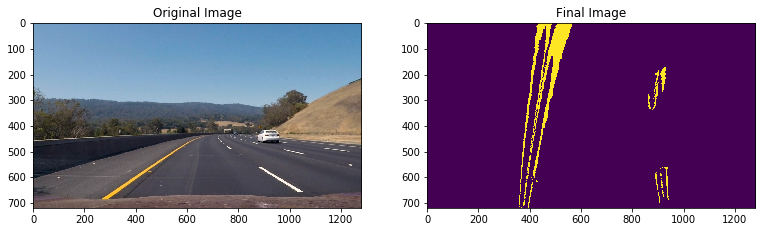

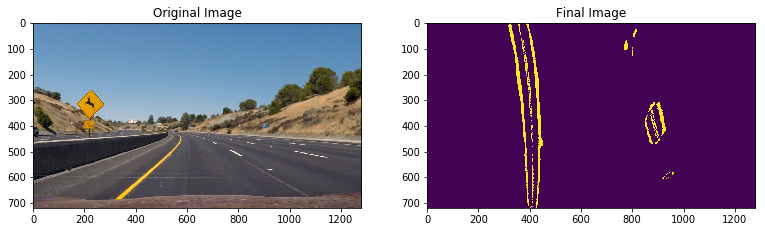

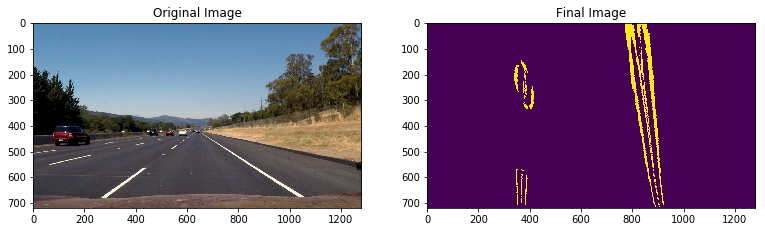

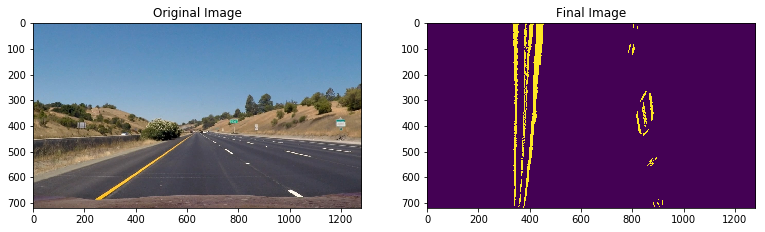

In [16]:
for fname in test_images:
    img = mpimg.imread(fname)
    # undistort
    dst = cal.undistort(img)
    # create binary mask
    _,_,mask = preprocessing.gradient_mask(img, settings, 'and')
    # roi
    roi = preprocessing.roi(mask, roi_src)
    # warp image
    warped = preprocessing.warp_image(roi, M)
    display([img, warped], ['Original Image', 'Final Image'], figsize=(20,8))